In [0]:
import pandas as pd
from sklearn.metrics import f1_score, classification_report
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import backend as K
from keras.regularizers import l1_l2
from keras.layers import LeakyReLU, BatchNormalization
from keras.optimizers import SGD
import numpy as np

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Функция для построения кривых обучения:

In [0]:
def plot_loss_acc(history):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10, 5)
    # summarize history for loss
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('model loss')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'test'], loc='upper left')

    # summarize history for accuracy
    ax[1].plot(history.history['acc'])
    ax[1].plot(history.history['val_acc'])
    ax[1].set_title('model accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'test'], loc='upper left')
    fig.show()

Размер изображений 200x200:

In [0]:
img_width = 200
img_height = 200

Создаем генераторы для подачи изображений в Keras:  
Для train добавляем data augmentation(сдвиги, увеличение и отражения по горизонтали), для validation только rescale

In [0]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'C:\\Users\\User\\Untitled Folder\\hotdog\\train',  # this is the target directory
        target_size=(img_width, img_height),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'C:\\Users\\User\\Untitled Folder\\hotdog\\test',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [0]:
def baseline_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Чекпоинт для сохранения лучшей модели:

In [0]:
filepath = '.\\models\\hotdog_baseline_reg_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min')

callbacks = [checkpoint]

In [0]:
baseline_model = baseline_model()

history = baseline_reg_model.fit_generator(
    train_generator,
    steps_per_epoch=1000 // batch_size,
    epochs=50,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=800 // batch_size)

Epoch 1/50
62/62 [==============================] - 17s 270ms/step - loss: 0.7094 - acc: 0.5150 - val_loss: 0.6935 - val_acc: 0.4987
Epoch 2/50
62/62 [==============================] - 16s 263ms/step - loss: 0.6946 - acc: 0.5142 - val_loss: 0.6925 - val_acc: 0.5355
Epoch 3/50
62/62 [==============================] - 15s 246ms/step - loss: 0.6925 - acc: 0.5262 - val_loss: 0.6925 - val_acc: 0.5063
Epoch 4/50
62/62 [==============================] - 15s 237ms/step - loss: 0.6904 - acc: 0.5141 - val_loss: 0.6931 - val_acc: 0.5025
Epoch 5/50
62/62 [==============================] - 15s 247ms/step - loss: 0.6909 - acc: 0.4909 - val_loss: 0.6930 - val_acc: 0.5114
Epoch 6/50
62/62 [==============================] - 14s 224ms/step - loss: 0.6840 - acc: 0.5284 - val_loss: 0.6889 - val_acc: 0.5254
Epoch 7/50
62/62 [==============================] - 13s 211ms/step - loss: 0.6853 - acc: 0.5715 - val_loss: 0.6833 - val_acc: 0.5482
Epoch 8/50
62/62 [==============================] - 14s 228ms/step - 

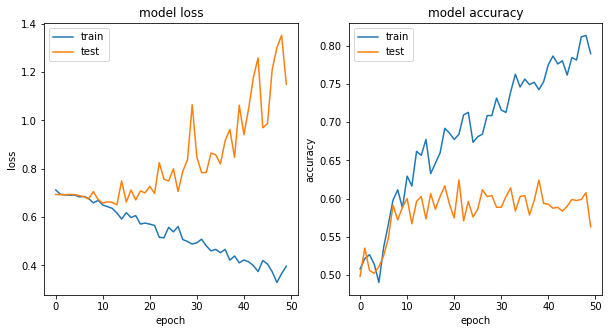

In [0]:
plot_loss_acc(history_reg)

In [0]:
model = load_model('.\\models\\hotdog_baseline_reg_model.hdf5')
result = model.evaluate_generator(validation_generator)
print('Loss for val: {}\nAccuracy for val: {}'.format(result[0], result[1]))

Loss for val: 0.6502834296226502
Accuracy for val: 0.606


In [0]:
predict_proba = model.predict_generator(validation_generator)
predictions = pd.Series(predict_proba.reshape((500,))).apply(lambda x: 1 if x < 0.5 else 0)
result_bs_f1 = f1_score(validation_labels, predictions)
print(classification_report(validation_labels, predictions))

             precision    recall  f1-score   support

          0       0.60      0.65      0.62       250
          1       0.62      0.56      0.59       250

avg / total       0.61      0.61      0.61       500



Небольшого колличества изображений(500) не хватает чтобы нормально обучить свою собственную сеть, поэтому более разумно будет использовать уже предобученную на большом кол-ве данных сеть для выделения признаков.

### 2. VGG16

Будем использовать предобученную на датасете соревнования ImageNet модель VGG16.   
Допиливание ее под нашу задачу состоит из 2 этапов:  
1) Сначала необходимо предобучить верхние полносвязные слои, которые будут решать нашу задачу. Для этого необходимо отрезать полносвязные слои у VGG16 и получить признаки, извлеченные из наших картинок с помощью оставшихся сверток VGG16. Используя эти признаки предобучаем наш полносвязный слой.  
2) Fine-tuning. Добавим предобученный полносвязный слой к сверточным от VGG и разморозим последний сверточный слой, где происходит выделение абстрактных признаков и дообучим его вместе с полносвязным слоем. Такой подход нельзя применить сразу в лоб, добавив случайно инициализированный полносвязный слой к сверткам VGG, поскольку при сильном изменении градиента при обучении случайных весов полносвязного слоя мы потеряем всю тонкую настройку для свертки и останемся у разбитого корыта.

### Train fully-connection top-layers:

In [0]:
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network
vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

Сохраняем результаты после сверточных слоев VGG:

In [0]:
batch_size = 16
nb_train_samples = 498
nb_validation_samples = 500

generator = datagen.flow_from_directory(
        'C:\\Users\\User\\Untitled Folder\\hotdog\\train',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = vgg16.predict_generator(generator, nb_train_samples // batch_size + 1)
# save the output as a Numpy array
np.save('bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
        'C:\\Users\\User\\Untitled Folder\\hotdog\\test',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
bottleneck_features_validation = vgg16.predict_generator(generator, nb_validation_samples // batch_size + 1)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

In [0]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=6, verbose=1, mode='min')
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=6, verbose=0, mode='min')

filepath = '.\\models\\hotdog_bottleneck_model_vgg16.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min')
callbacks = [checkpoint]

In [0]:
train_data = np.load('bottleneck_features_train.npy')
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

Теперь обучаем нашу хотдоговую полносвязную часть:

In [0]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(32, activation='relu',
                kernel_initializer='he_uniform',
                kernel_regularizer=l1_l2(1e-6, 1e-6), 
                bias_regularizer=l1_l2(1e-6, 1e-6), 
                activity_regularizer=l1_l2(1e-6, 1e-6)))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_bottleneck = model.fit(train_data, train_labels,
                               epochs=60,
                               batch_size=batch_size,
                               callbacks=callbacks,
                               validation_data=(validation_data, validation_labels))

Train on 498 samples, validate on 500 samples
Epoch 1/60
498/498 [==============================] - 7s 15ms/step - loss: 0.7200 - acc: 0.5261 - val_loss: 0.6507 - val_acc: 0.5820
Epoch 2/60
498/498 [==============================] - 0s 851us/step - loss: 0.6469 - acc: 0.5723 - val_loss: 0.6119 - val_acc: 0.6780
Epoch 3/60
498/498 [==============================] - 0s 891us/step - loss: 0.5834 - acc: 0.6104 - val_loss: 0.5959 - val_acc: 0.6720
Epoch 4/60
498/498 [==============================] - 0s 903us/step - loss: 0.6168 - acc: 0.5884 - val_loss: 0.5456 - val_acc: 0.7480
Epoch 5/60
498/498 [==============================] - 0s 971us/step - loss: 0.5719 - acc: 0.6285 - val_loss: 0.5276 - val_acc: 0.7720
Epoch 6/60
498/498 [==============================] - 0s 827us/step - loss: 0.5215 - acc: 0.6586 - val_loss: 0.5296 - val_acc: 0.7640
Epoch 7/60
498/498 [==============================] - 0s 847us/step - loss: 0.4935 - acc: 0.6847 - val_loss: 0.4997 - val_acc: 0.7700
Epoch 8/60
498/49

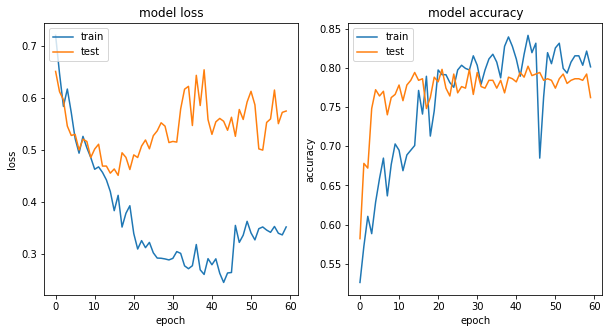

In [0]:
plot_loss_acc(history_bottleneck)

In [0]:
model = load_model('.\\models\\hotdog_bottleneck_model_vgg16.hdf5')
model.save_weights('.\\models\\hotdog_bottleneck_model_vgg16_weights.h5')
result = model.evaluate(validation_data, validation_labels)
print('Loss for val: {}\nAccuracy for val: {}'.format(result[0], result[1]))

500/500 [==============================] - 3s 6ms/step
Loss for val: 0.4524593043327332
Accuracy for val: 0.7860000004768372


In [0]:
predict = model.predict_classes(validation_data)
result_bn_f1 = f1_score(validation_labels, predict)
print(classification_report(validation_labels, predict))

             precision    recall  f1-score   support

          0       0.79      0.78      0.78       250
          1       0.78      0.79      0.79       250

avg / total       0.79      0.79      0.79       500



Получили неплохой прирост для метрик

### Fine-tuning

In [0]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(32, activation='relu',
                kernel_initializer='he_uniform',
                kernel_regularizer=l1_l2(1e-6, 1e-6), 
                bias_regularizer=l1_l2(1e-6, 1e-6), 
                activity_regularizer=l1_l2(1e-6, 1e-6)))
top_model.add(Dropout(0.6))
top_model.add(Dense(1, activation='sigmoid'))

In [0]:
# load pre-trained weights
top_model.load_weights('.\\models\\hotdog_bottleneck_weights.h5')

Создаем модель для fine-tuning:

In [0]:
# create new model for fine-tuning
# add layers from vgg16
fine_tune_model = Sequential()
for layer in vgg16.layers:
    fine_tune_model.add(layer)

fine_tune_model.add(top_model)

Замораживаем первые блоки сверток, оставляя только последний блок и полносвязный слой:  
А так же будем использовать SGD оптимизатор с низким learning rate, чтобы случайно не разрушать ранее изученные признаки

In [0]:
# set the first 14 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in fine_tune_model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
fine_tune_model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=4, verbose=1, mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, verbose=0, mode='min')

filepath = '.\\models\\hotdog_finetune_model_vgg16.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min')
callbacks = [checkpoint, early_stop, reduce_lr]

In [0]:
batch_size = 16

# fine-tune the model
history_ft = fine_tune_model.fit_generator(
    train_generator,
    steps_per_epoch = 498 // batch_size,
    epochs=50,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps = 500 // batch_size)

Epoch 1/50
31/31 [==============================] - 13s 410ms/step - loss: 0.3965 - acc: 0.7623 - val_loss: 0.4918 - val_acc: 0.7722
Epoch 2/50
31/31 [==============================] - 11s 355ms/step - loss: 0.3605 - acc: 0.8164 - val_loss: 0.4654 - val_acc: 0.7903
Epoch 3/50
31/31 [==============================] - 12s 371ms/step - loss: 0.3725 - acc: 0.8047 - val_loss: 0.4912 - val_acc: 0.7883
Epoch 4/50
31/31 [==============================] - 11s 360ms/step - loss: 0.3655 - acc: 0.8004 - val_loss: 0.4408 - val_acc: 0.8085
Epoch 5/50
31/31 [==============================] - 11s 369ms/step - loss: 0.3879 - acc: 0.8083 - val_loss: 0.4408 - val_acc: 0.8065
Epoch 6/50
31/31 [==============================] - 11s 360ms/step - loss: 0.3578 - acc: 0.8283 - val_loss: 0.4890 - val_acc: 0.7883
Epoch 7/50
31/31 [==============================] - 11s 371ms/step - loss: 0.3486 - acc: 0.8285 - val_loss: 0.4550 - val_acc: 0.8004
Epoch 8/50
31/31 [==============================] - 11s 359ms/step - 

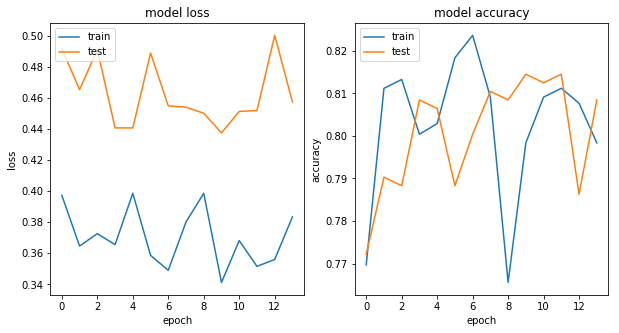

In [0]:
plot_loss_acc(history_ft)

In [0]:
predict_proba = fine_tune_model.predict_generator(validation_generator)
predictions = pd.Series(predict_proba.reshape((500,))).apply(lambda x: 1 if x < 0.5 else 0)
result_ft_f1 = f1_score(validation_labels, predictions)
print(classification_report(validation_labels, predictions))

             precision    recall  f1-score   support

          0       0.76      0.89      0.82       250
          1       0.87      0.72      0.79       250

avg / total       0.82      0.81      0.81       500



В итоге удалось достигнуть accuracy порядка 0.81 и f1 порядка 0.79 для такого маленького датасета хотдогов и не хотдогов.

In [0]:
pd.DataFrame([result_bs_f1, result_bn_f1, result_ft_f1], columns=['f1_score'], index=['baseline_conv', 'VGG16_bottleneck', 'VGG16_finetune'])

,f1_score
baseline_conv,0.587002
VGG16_bottleneck,0.781903
VGG16_finetune,0.790393


### Выводы:
* Имея маленький датасет разумнее будет не обучать свою архитектуру с нуля, а лучше воспользоваться transfer learning для предобученной модели
* Нужно с осторожностью относится к процессу fine-tunnig, чтобы сохранить способности сверточных слоев к выделению качественных признаков